# Sorghum growth

In [1]:
from __future__ import annotations

import os
import sys
import time as t
from datetime import date
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

sys.path.append("../data") 
from archi_dict import archi_sorghum_angles as archi
from oawidgets.plantgl import *  # noqa: F403

from openalea.archicrop.stand import agronomic_plot
from openalea.archicrop.display import build_scene, display_scene  # noqa: F401
from openalea.archicrop.simulation import (
    plot_constained_vs_pot,
    plot_constrainted_vs_realized,
    plot_faPAR,
    plot_PAR,
    run_simulations,
    write_netcdf,
)
from openalea.plantgl.all import Color3, Material, Scene, Viewer  # noqa: F401

%gui qt

In [2]:
stics_color = "orange"
archicrop_color = "green"

In [3]:
tec_file_xml='../data/02NT18SorgV2D1_tec.xml'
plt_file_xml='../data/sorgho_imp_M_v10_plt.xml'
stics_output_file='../data/mod_s02NT18SorgV2D1.sti'
weather_file = '../data/ntarla_corr.2018'
location = {  
'longitude': 3.87,
'latitude': 12.58,
'altitude': 800,
'timezone': 'Europe/Paris'}

In [4]:
seed = 18

In [ ]:

start_time = t.time()

daily_dynamics, params_sets, pot_la, pot_h, realized_la, realized_h, nrj_per_plant, mtgs, filters, density = run_simulations(
    archi_params=archi, 
    tec_file=tec_file_xml, 
    plant_file=plt_file_xml, 
    dynamics_file=stics_output_file, 
    weather_file=weather_file,
    location=location,
    n_samples=6,
    latin_hypercube=False,
    pot_factor=1.4,
    opt_filter_organ_duration=False,
    opt_filter_pot_growth=False,
    opt_filter_realized_growth=False,
    light_inter=False,
    direct=False,
    error_LA_pot=1,
    error_height_pot=1,
    error_LA_realized=1,
    error_height_realized=1,
    seed=seed)

end_time = t.time()

elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.4f} minutes for {len(realized_la)} simulations")  # noqa: T201


Elapsed time: 0.2969 minutes for 12 simulations


In [6]:
# Retrieve STICS growth and senescence dynamics
dates = [value["Date"] for value in daily_dynamics.values()]
thermal_time = [value["Thermal time"] for value in daily_dynamics.values()]
leaf_area_plant = [value["Plant leaf area"] for value in daily_dynamics.values()]
sen_leaf_area_plant = [value["Plant senescent leaf area"] for value in daily_dynamics.values()]
height_canopy = [value["Plant height"] for value in daily_dynamics.values()]
par_incident = [value["Incident PAR"] for value in daily_dynamics.values()]
par_stics = [value["Absorbed PAR"] for value in daily_dynamics.values()]

In [ ]:
write_netcdf("sorghum_growth_tillers", daily_dynamics, params_sets, pot_la, pot_h, realized_la, realized_h, nrj_per_plant, mtgs, filters, density, seed)

In [8]:
# Viewer.display(build_scene(mtgs[3][-30])[0])

In [9]:
# mtgs[3][-40].properties()['potential_growth_rate']

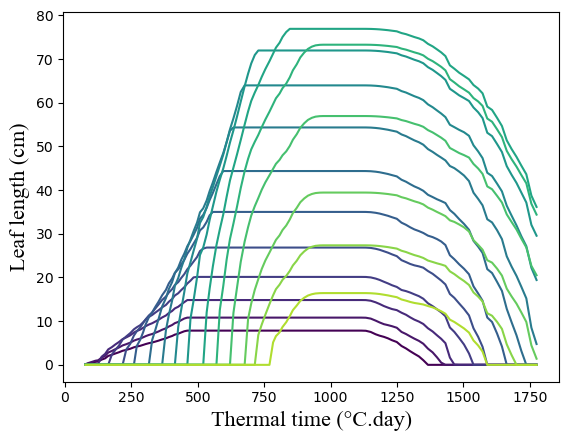

In [10]:
import os
from datetime import date

### Plot leaf lengths
id = 5
norm = plt.Normalize(0, len(mtgs[id][1].properties()["leaf_lengths"].values())+1)
cmap = plt.get_cmap('viridis')  # You can choose any matplotlib colormap

for l in range(len(mtgs[id][100].properties()["leaf_lengths"].values())):  # noqa: E741
    # print(list(growing_plant[time[1]].properties()["leaf_lengths"].values()))
    # print(list(growing_plant[time[-1]].properties()["leaf_lengths"].values()))
    color = cmap(norm(l))
    plt.plot(thermal_time[1:], 
             [list(mtgs[id][t].properties()["leaf_lengths"].values())[l][-1] - list(mtgs[id][t].properties()["senescent_lengths"].values())[l][-1] for t in range(len(thermal_time[1:]))], 
             color=color)

plt.xlabel("Thermal time (°C.day)", fontsize=16, fontname="Times New Roman")
plt.ylabel("Leaf length (cm)", fontsize=16, fontname="Times New Roman")
# plt.legend(loc="upper left")

# Save figure
today_str = date.today().strftime("%Y-%m-%d")
os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_leaf_lengths.png")

plt.show()

TypeError: 'int' object is not subscriptable

<Figure size 640x480 with 0 Axes>

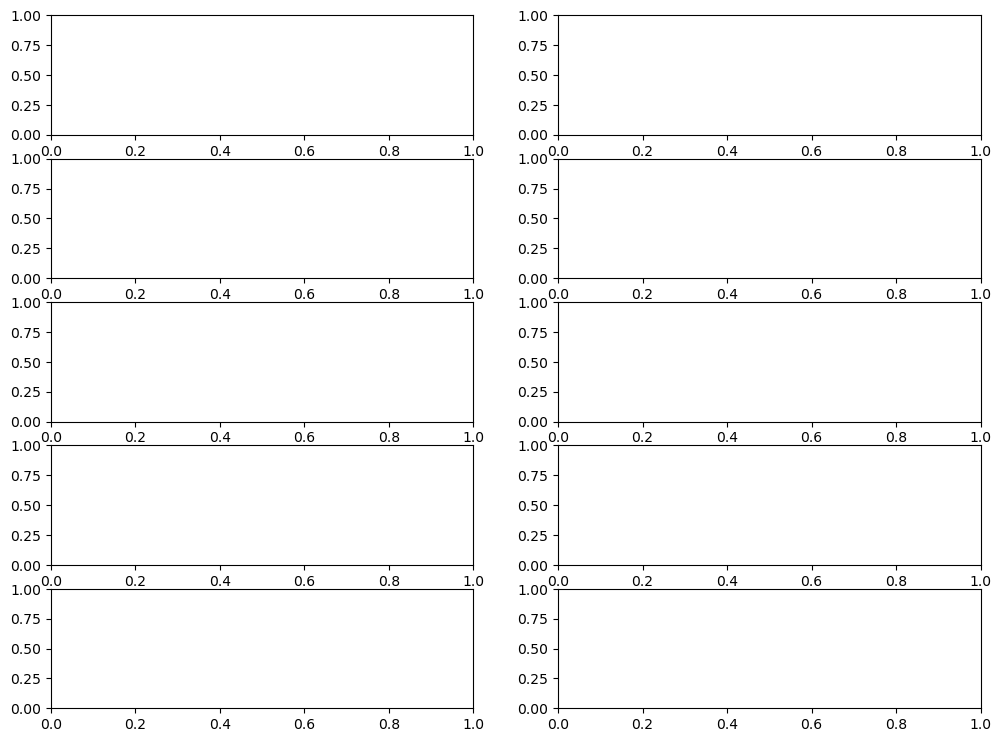

In [11]:
from openalea.archicrop.cereal_axis import bell_shaped_dist
import math
from openalea.archicrop.simulation import get_end_veg

index_end_veg, end_veg = get_end_veg(daily_dynamics)

### Plot leaf areas
plt.clf()
fig, ax = plt.subplots(5, 2, figsize=(12, 9))

# flatten axes to a 1D array for easy indexing, even if there is only one axis
if isinstance(ax, np.ndarray):
    ax_flat = ax.flatten()
else:
    ax_flat = np.array([ax])

n = {}
for i, phi in enumerate(np.linspace(archi['phyllochron'][0], archi['phyllochron'][1], 10)):
    nb = math.floor((end_veg-thermal_time[0]-phi * archi['leaf_duration'])/phi)
    n[nb] = i

first = True
for id in mtgs:
    leaf_areas = []
    for l in range(len(mtgs[id][1].properties()["visible_leaf_area"].values())):  # noqa: E741
        leaf_areas.append(list(mtgs[id][-1].properties()["visible_leaf_area"].values())[l])

    bell_shape = bell_shaped_dist(params_sets[id]['leaf_area'], params_sets[id]['nb_phy'], params_sets[id]['rmax'], params_sets[id]['skew'])
    ax_i = ax_flat[n[params_sets[id]['nb_phy']]]
    if first:
        ax_i.plot(range(1, len(bell_shape) + 1), bell_shape, color='orange', alpha=0.5, label="Potential bell-shaped distribution")
        ax_i.plot(range(1, len(leaf_areas) + 1), leaf_areas, color="green", alpha=0.5, label="Simulated leaf areas")
        first = False
    else:
        ax_i.plot(range(1, len(bell_shape) + 1), bell_shape, color='orange', alpha=0.5)
        ax_i.plot(range(1, len(leaf_areas) + 1), leaf_areas, color="green", alpha=0.5)

# set common labels
fig.text(0.5, 0.04, "Nb of leaves", ha='center', fontsize=16, fontname="Times New Roman")
fig.text(0.04, 0.5, "Mature leaf area (cm²)", va='center', rotation='vertical', fontsize=16, fontname="Times New Roman")

fig.legend()

# Save figure
today_str = date.today().strftime("%Y-%m-%d")
os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_leaf_areas.png")

plt.show()

<Figure size 640x480 with 0 Axes>

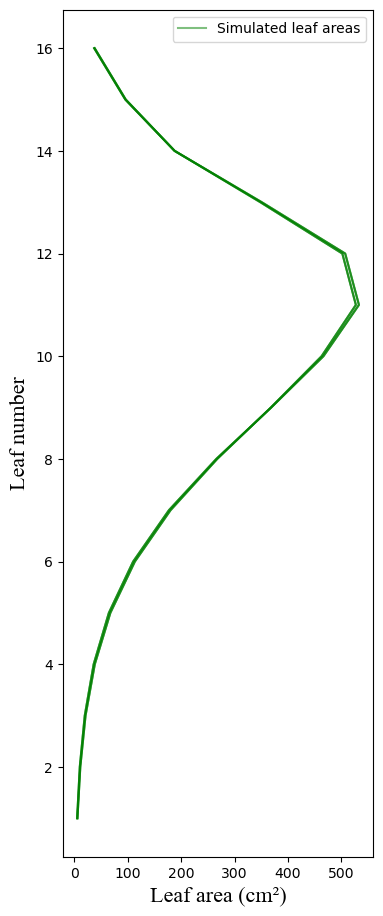

In [12]:
### Plot leaf areas
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(4, 11))

first = True
for id in mtgs:
    if params_sets[id]['nb_phy'] < 10:
        continue
    leaf_areas = []
    leaf_lengths = []
    leaf_widths = []
    if list(mtgs[id][-32].properties()["visible_length"].values())[-1] < 15:
        continue
    if list(mtgs[id][-32].properties()["visible_length"].values())[1] > 15:
        continue
    for leaf in mtgs[id][-32].properties()["visible_leaf_area"]:
        leaf_areas.append(mtgs[id][-32].properties()["visible_leaf_area"][leaf])
        leaf_lengths.append(mtgs[id][-32].properties()["visible_length"][leaf])
        leaf_widths.append(mtgs[id][-32].properties()["visible_length"][leaf] * params_sets[id]['wl'])
    # bell_shape = bell_shaped_dist(params_sets[id]['leaf_area'], params_sets[id]['nb_phy'], params_sets[id]['rmax'], params_sets[id]['skew'])

    if first:
        ax.plot(leaf_areas, range(1, len(leaf_areas) + 1), color="green", alpha=0.5, label="Simulated leaf areas")
        # ax[1].plot(range(1, len(leaf_areas) + 1), leaf_lengths, color="green", alpha=0.5, label="Simulated leaf lengths")
        # ax[2].plot(range(1, len(leaf_areas) + 1), leaf_widths, color="green", alpha=0.5, label="Simulated leaf widths")
        first = False
    else:
        ax.plot(leaf_areas, range(1, len(leaf_areas) + 1), color="green", alpha=0.5)
        # ax[1].plot(range(1, len(leaf_areas) + 1), leaf_lengths, color="green", alpha=0.5)
        # ax[2].plot(range(1, len(leaf_areas) + 1), leaf_widths, color="green", alpha=0.5)

ax.set_xlabel("Leaf area (cm²)", fontsize=16, fontname="Times New Roman") 
ax.set_ylabel("Leaf number", fontsize=16, fontname="Times New Roman")
ax.legend()

# ax[1].set_ylabel("Leaf length (cm)", fontsize=16, fontname="Times New Roman") 
# ax[1].set_xlabel("Leaf number", fontsize=16, fontname="Times New Roman")
# ax[1].legend()

# ax[2].set_ylabel("Leaf width (cm)", fontsize=16, fontname="Times New Roman") 
# ax[2].set_xlabel("Leaf number", fontsize=16, fontname="Times New Roman")
# ax[2].legend()

# Save figure
today_str = date.today().strftime("%Y-%m-%d")
os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_leaf_areas_lengths_widths.png")

plt.show()

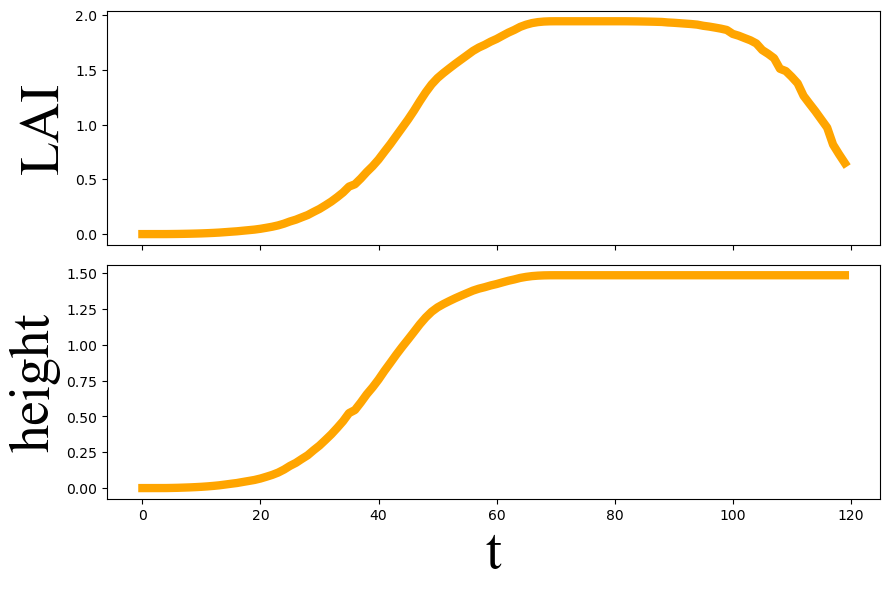

In [ ]:
from matplotlib.lines import Line2D


# conversion factor
cf_cm = 100

fig, axes = plt.subplots(2, 1, figsize=(9, 6), sharex=True)  # 1 row, 2 columns

axes[0].plot(range(len(dates)), [(la-sen)*density/cf_cm**2 for la, sen in zip(leaf_area_plant, sen_leaf_area_plant)], color=stics_color, linewidth=6)
# for result in realized_la.values():
#     if result[0] is not None:
#         axes[0].plot(dates, [r*density/cf_cm**2 for r in result], color=archicrop_color) #, alpha=0.6)
axes[0].set_ylabel("LAI", fontsize=40, fontname="Times New Roman")
# axes[0].set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/9))
# axes[0].set_title("Leaf Area: 3D canopy vs. STICS")
# axes[0].legend(loc=2)

# legend_elements_lai = [
#     Line2D([0], [0], color=stics_color, alpha=0.9, lw=6, label='STICS'),
#     Line2D([0], [0], color=archicrop_color, alpha=0.6, lw=2, label='ArchiCrop morphotypes')
# ]
# axes[0].legend(handles=legend_elements_lai, loc=2, prop={'family': 'Times New Roman', 'size': 12})


axes[1].plot(range(len(dates)), [h/cf_cm for h in height_canopy], color=stics_color, linewidth=6)
# for result in realized_h.values():
#     if result[0] is not None:
#         axes[1].plot(dates, [r/cf_cm for r in result], color=archicrop_color) #, alpha=0.6)
axes[1].set_xlabel("t", fontsize=40, fontname="Times New Roman")
axes[1].set_ylabel("height", fontsize=40, fontname="Times New Roman")
# axes[0].set_xticks(np.arange(0, len(dates)+1, (len(dates)+1)/9))
# axes[1].set_title("Plant height: 3D canopy vs. STICS")

# legend_elements_height = [
#     Line2D([0], [0], color=stics_color, alpha=0.9, lw=6, label='STICS'),
#     Line2D([0], [0], color=archicrop_color, alpha=0.6, lw=2, label='ArchiCrop morphotypes')
# ]
# axes[1].legend(handles=legend_elements_height, loc=2, prop={'family': 'Times New Roman', 'size': 12})

# Adjust layout
plt.tight_layout()

# Save figure
today_str = date.today().strftime("%Y-%m-%d")
os.makedirs(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}", exist_ok=True)  # noqa: PTH103
plt.savefig(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/plot_constrainted_vs_realized.png")

# Show the plot
plt.show()

In [ ]:
### Plot the 3D scene
# times = [t for i,t in enumerate(thermal_time) if i%10==0]
# mean_time = sum(times) / len(times)
# positions = [ (1*(t-mean_time), 0, 0) for t in times]
# nice_green = Color3((40, 80, 0))
# scene, _ = build_scene(
#     [g for i,g in enumerate(mtgs[id]) if i%10==0], 
#     position=positions, 
#     senescence=True, 
#     leaf_material = Material(nice_green), 
#     stem_material=Material(nice_green))
# display_scene(scene)

In [ ]:
len(mtgs)

36

In [ ]:
nice_green = Color3((40, 80, 0))
nplants, positions, domain, domain_area, unit = agronomic_plot(length=1, width=1, density=density, inter_row=0.4, noise=0.15)
# scene, nump = build_scene(mtgs[40][-32], positions, senescence=True, leaf_material=Material(nice_green), stem_material=Material(nice_green))
# Viewer.camera.lookAt((0,0,500), (0,0,0))
# display_scene(scene)

# for id,mtg in mtgs.items():
#     scene, nump = build_scene(mtg[-32], positions, senescence=True, leaf_material=Material(nice_green), stem_material=Material(nice_green))
#     Viewer.display(scene)
#     Viewer.grids.setXYPlane(False)
#     Viewer.grids.setYZPlane(False)
#     Viewer.grids.setXZPlane(False)
#     Viewer.camera.lookAt((0,0,500), (0,0,0))
#     Viewer.frameGL.saveImage(f"D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/sorghum_{params_sets[id]['insertion_angle']}_{params_sets[id]['curvature']}_{params_sets[id]['phyllotactic_angle']}.png")

In [ ]:
from openalea.archicrop.light_it import illuminate
%gui qt

par_incident = [value["Incident PAR"] for value in daily_dynamics.values()]

id = 10
mtgs_plant = mtgs[id]
t = -32
mtg = mtgs_plant[t]
par = par_incident[t]
lights = [(1,(0,0,-1))]
scene, labels = build_scene(mtg, positions, senescence=True, leaf_material=Material(nice_green), stem_material=Material(nice_green))
cs, raw, agg = illuminate(scene=scene, light=lights, labels=labels, domain=domain, direct=False) # --> cf PARaggregators in caribu scene node
scene, values = cs.plot(raw, display=False)
v99 = np.percentile(values, 99)
nvalues=np.array(values)
nvalues[nvalues>v99]=v99
values = nvalues.tolist()
PlantGL(scene, group_by_color=False, property=values)
# scene_tmp = cs.plot(raw, display=False)[0]
# scene_tmp.save(f'D:/PhD_Oriane/simulations_ArchiCrop/{today_str}/illuminated_scene_{i}.png') # not as images !!!

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…